# Libraries

In [2]:
import pandas as pd
import os
import numpy as np

#data cleansing
from sklearn.preprocessing import OneHotEncoder


#logistic regression
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


#Export model
import pickle

# Read data

In [4]:
# fetch all the data from the raw_data folder
current_dir = os.getcwd()
current_dir

file_path = os.path.join(current_dir, '..','raw_data', 'data.csv')
df = pd.read_csv(file_path, nrows=10000)

# Getting the data

In [1]:
columns_keep = [
#'division_number',
#'date_reported',
'date_occurred',
#'area',
#'area_name',
#'reporting_district',
#'part',
#'crime_code',
'crime_description',
#'modus_operandi',
'victim_age',
'victim_sex',
'victim_descent',
#'premise_code',
#'premise_description',
#'weapon_code',
#'weapon_description',
#'status',
#'status_description',
#'crime_code_1',
#'crime_code_2',
#'crime_code_3',
#'crime_code_4',
#'location',
#'cross_street',
'latitude',
'longitude',
]

In [5]:
df = df[columns_keep]
df.head(3)

,date_occurred,crime_description,victim_age,victim_sex,victim_descent,latitude,longitude
0,2020-01-08 22:30:00,BATTERY - SIMPLE ASSAULT,36,F,B,34.0141,-118.2978
1,2020-01-01 03:30:00,BATTERY - SIMPLE ASSAULT,25,M,H,34.0459,-118.2545
2,2020-02-13 12:00:00,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,0,X,X,34.0448,-118.2474


# Data Cleansing

## 1. Basic Cleansing

In [6]:
#Removing illogical values and replacing erronous values

#removing negative age values
df=df[df['victim_age']>=0]

#removing null gender values
df = df[df['victim_sex'].notnull()]
df = df[df['victim_descent'].notnull()]


In [7]:
#exploring unique values for victim descent and victim sex columns
df['victim_sex'].unique(), df['victim_descent'].unique()

(array(['F', 'M', 'X', 'H'], dtype=object),
 array(['B', 'H', 'X', 'W', 'A', 'O', 'C', 'F', 'K', 'I', 'V', 'Z', 'J',
        'P'], dtype=object))

In [8]:
# from the above cell , '-' is present in both columns so we need to remove rows that contain it (they're not that many)
df=df[df['victim_sex'] != '-']
df=df[df['victim_descent'] != '-']

In [10]:
#checking the above code worked
df['victim_sex'].unique(), df['victim_descent'].unique()

(array(['F', 'M', 'X', 'H'], dtype=object),
 array(['B', 'H', 'X', 'W', 'A', 'O', 'C', 'F', 'K', 'I', 'V', 'Z', 'J',
        'P'], dtype=object))

In [11]:
# Parse datetime string to datetime object

df['date_occurred'] = pd.to_datetime(df['date_occurred'], errors='coerce')

#create new date and time columns
df['year_occurred'] = df['date_occurred'].dt.year
df['month_occurred'] = df['date_occurred'].dt.month
df['hour_occurred'] = df['date_occurred'].dt.hour
df['day_occurred'] = df['date_occurred'].dt.day

df.head(3)

,date_occurred,crime_description,victim_age,victim_sex,victim_descent,latitude,longitude,year_occurred,month_occurred,hour_occurred,day_occurred
0,2020-01-08 22:30:00,BATTERY - SIMPLE ASSAULT,36,F,B,34.0141,-118.2978,2020,1,22,8
1,2020-01-01 03:30:00,BATTERY - SIMPLE ASSAULT,25,M,H,34.0459,-118.2545,2020,1,3,1
2,2020-02-13 12:00:00,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,0,X,X,34.0448,-118.2474,2020,2,12,13


In [13]:
# Create new column 'time_of_day' based on time
def categorize_time(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

df['time_of_day'] = df['hour_occurred'].apply(categorize_time)

## 1.2 one hot encoding victim_sex and victim_descent

In [15]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [16]:
df = pd.get_dummies(df, columns=['victim_descent', 'victim_sex'])
df = df.replace({True: 1, False: 0})

df.head()

/tmp/ipykernel_703756/3463276855.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0})


,date_occurred,crime_description,victim_age,latitude,longitude,year_occurred,month_occurred,hour_occurred,day_occurred,time_of_day,victim_descent_A,victim_descent_B,victim_descent_C,victim_descent_F,victim_descent_H,victim_descent_I,victim_descent_J,victim_descent_K,victim_descent_O,victim_descent_P,victim_descent_V,victim_descent_W,victim_descent_X,victim_descent_Z,victim_sex_F,victim_sex_H,victim_sex_M,victim_sex_X
0,2020-01-08 22:30:00,BATTERY - SIMPLE ASSAULT,36,34.0141,-118.2978,2020,1,22,8,evening,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2020-01-01 03:30:00,BATTERY - SIMPLE ASSAULT,25,34.0459,-118.2545,2020,1,3,1,night,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2020-02-13 12:00:00,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,0,34.0448,-118.2474,2020,2,12,13,afternoon,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,2020-01-01 17:30:00,VANDALISM - MISDEAMEANOR ($399 OR UNDER),76,34.1685,-118.4019,2020,1,17,1,afternoon,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,2020-01-01 04:15:00,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",31,34.2198,-118.4468,2020,1,4,1,night,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


# Logistic regression

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9135 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date_occurred      9135 non-null   datetime64[ns]
 1   crime_description  9135 non-null   object        
 2   victim_age         9135 non-null   int64         
 3   latitude           9135 non-null   float64       
 4   longitude          9135 non-null   float64       
 5   year_occurred      9135 non-null   int32         
 6   month_occurred     9135 non-null   int32         
 7   hour_occurred      9135 non-null   int32         
 8   day_occurred       9135 non-null   int32         
 9   time_of_day        9135 non-null   object        
 10  victim_descent_A   9135 non-null   int64         
 11  victim_descent_B   9135 non-null   int64         
 12  victim_descent_C   9135 non-null   int64         
 13  victim_descent_F   9135 non-null   int64         
 14  victim_descen

## Cross validate

In [18]:
#Create the feature set

X = df[['victim_age','latitude','longitude',]]
y = df['crime_description']

# Instanciate model
model = LogisticRegression(max_iter=10000)

# 5-Fold Cross validate model
#`cross_validate` doesn't return a fitted model
cv_results = cross_validate(model, X, y, cv=5)

# Mean of accuracies
accuracy = cv_results['test_score'].mean()

accuracy

/home/elie/.pyenv/versions/3.10.6/envs/safe_live/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 

## Learning curves

/home/cris/.pyenv/versions/3.10.6/envs/safe_live/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=20.
  warnings.warn(
/home/cris/.pyenv/versions/3.10.6/envs/safe_live/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cris/.pyenv/versions/3.10.6/envs/safe_live/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

I

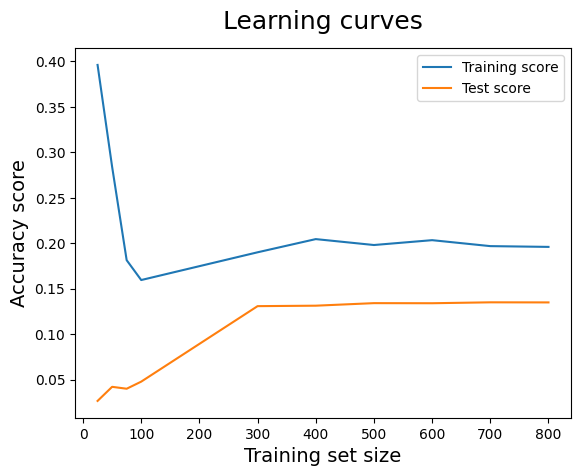

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = LogisticRegression(max_iter=1000),
                                                              X = X,
                                                              y = y,
                                                              train_sizes = [25,50,75,100,300,400,500,600,700,800],
                                                              cv = 20)

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curves!
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('Accuracy score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
#plt.xlim([0, 1000])
#plt.ylim([0, 1])
plt.legend()

## Prediction

In [8]:
#Holdout 30% of the dataset as the test set for a final evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,
                                                    random_state=0)


# STEP 1 - Instantiate and train the model on the training data
log_model = LogisticRegression(max_iter=10000).fit(X_train, y_train)


# # STEP 2 - Predictions on the test set
# Evaluate the model
log_model.score(X_test, y_test)
#y_pred = log_model.predict(X_test)




# Use the trained model to predict
prediction = log_model.predict([[18,34.0141,-118.2978,]])

prediction

/home/cris/.pyenv/versions/3.10.6/envs/safe_live/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cris/.pyenv/versions/3.10.6/envs/safe_live/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array(['THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)'],
      dtype=object)

# Export model

In [9]:
# Export model as pickle file
with open("ml_model.pkl", "wb") as file:
    pickle.dump(log_model, file)

# Load Pipeline from pickle file
my_model = pickle.load(open("ml_model.pkl","rb"))

my_model.score(X_test, y_test)

0.348

# Import model

In [10]:
# Load pipeline from pickle file
my_model = pickle.load(open("ml_model.pkl", "rb"))

my_model

LogisticRegression(max_iter=10000)